In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Explore the Measurement data
inspector = inspect(engine)
inspector.get_table_names()

Measurement_columns = inspector.get_columns('Measurement')
for c in Measurement_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Explore the Stations data
Station_columns = inspector.get_columns('Station')
for c in Station_columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [13]:
## UNDERSTAND the data
# Find the latest date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Find the earliest date
session.query(Measurement.date).order_by(Measurement.date).first()

## Date range: 2010-01-01 to 2017-08-23

# Choose the dates for vacation: 2017-07-10 to 2017-07-17

('2010-01-01')

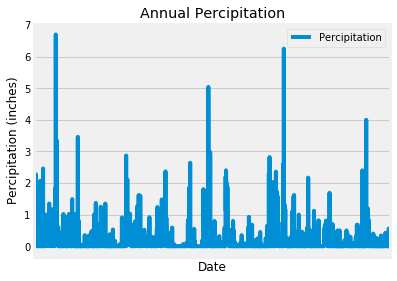

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
year_ago_date = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
yr_ago_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
annual_prcp = pd.DataFrame(yr_ago_prcp, columns=['Date','Percipitation'])
annual_prcp_dropna = pd.DataFrame(annual_prcp.dropna()).set_index('Date')

# Sort the dataframe by date
graph_1 = annual_prcp_dropna.sort_index(axis=0, ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
graph_1.plot()
plt.tight_layout()
plt.xlabel('Date')
plt.ylabel('Percipitation (inches)')
plt.title('Annual Percipitation')
plt.xticks([])
plt.show()

In [15]:
yr_ago_prcp

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

![precipitation](Images/precipitation.png)

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
annual_prcp_dropna.describe()

,Percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [17]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station)
stations.count()

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.station)]
station_counts = session.query(*sel).\
    group_by(Measurement.station).all()


# Station count table in Pandas
station_ct_df = pd.DataFrame(station_counts, columns=['Station ID','Observation Count'])
station_ct_table = station_ct_df.sort_values(['Observation Count'], ascending = False)
station_ct_table

,Station ID,Observation Count
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# Lowest, highest, and average temp at USC00519281
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
temp_hi_lo_avg = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').all()
temp_hi_lo_avg

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 1.0, 'Frequency of Temperatures at Station USC00519281 (over 1 year period)')

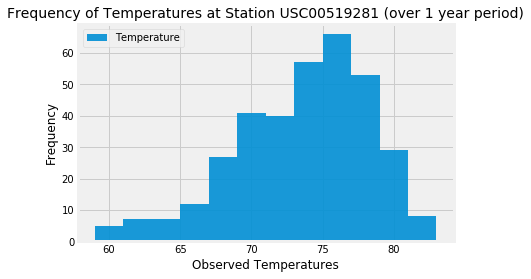

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.tobs]
tobs_freq = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= year_ago_date).\
    order_by(Measurement.date).all()
tobs_freq_df = pd.DataFrame(tobs_freq, columns = ['Temperature'])

ax = tobs_freq_df.plot.hist(bins=12, alpha=0.9)
plt.xlabel('Observed Temperatures', fontsize=12)
plt.title('Frequency of Temperatures at Station USC00519281 (over 1 year period)', fontsize=14)

![precipitation](Images/station-histogram.png)

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = pd.DataFrame(calc_temps('2017-08-01', '2017-08-14'), columns=['Min', 'Avg', 'Max'])
trip_temp

,Min,Avg,Max
0,71.0,79.017857,84.0


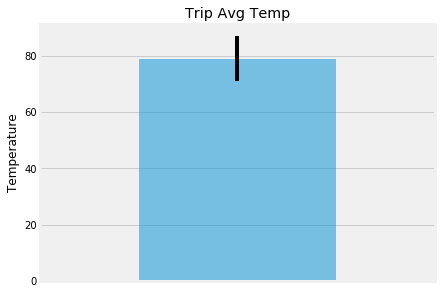

In [40]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_temp['Avg'].plot(kind='bar', yerr=(trip_temp['Avg'] - trip_temp['Min'],trip_temp['Max'] - trip_temp['Avg']), alpha=.5)
plt.tight_layout()
plt.title('Trip Avg Temp')
plt.ylabel('Temperature')
plt.xticks([])
plt.show()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


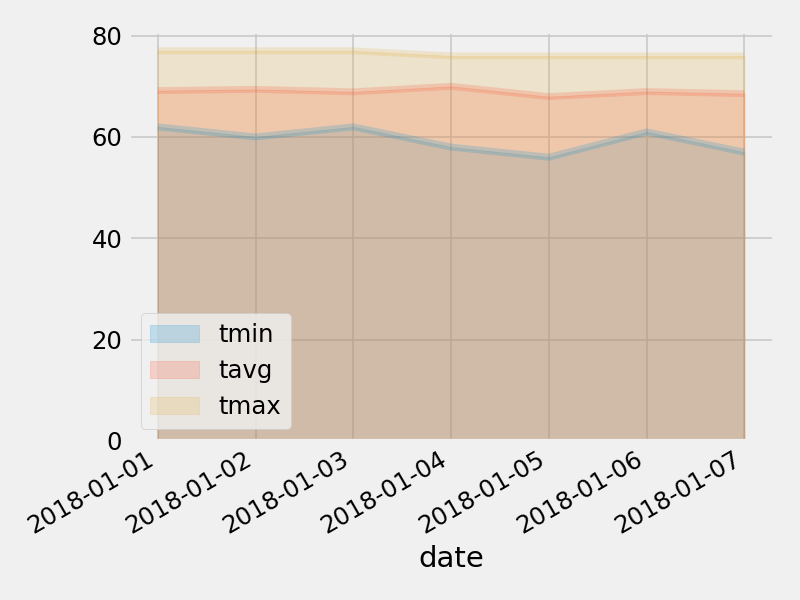

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
